In [12]:
import tensorflow as tf
from veggideas.transfer import load_non_trainable_model
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, layers
from keras import models
from keras import optimizers
from veggideas.load_data import load_train_data, load_val_data

In [13]:
train_data = load_train_data()
val_data = load_val_data()
base_model = load_non_trainable_model()

Found 15000 files belonging to 15 classes.
Loading training data
Training data successfully loaded ✅
Found 3000 files belonging to 15 classes.
Loading validation data
Validation data successfully loaded ✅


In [14]:
small_val_data = val_data.take(5)
small_train_data = train_data.take(5)

In [ ]:
def data_augmentation():
    datagen = ImageDataGenerator(
        rotation_range=20,  # Rotate images by 20 degrees
        width_shift_range=0.2,  # Shift images horizontally by 20% of the total width
        height_shift_range=0.2,  # Shift images vertically by 20% of the total height
        shear_range=0.2,  # Apply shear transformation with a shear intensity of 20%
        zoom_range=0.2,  # Apply zoom transformation with a zoom range of 20%
        horizontal_flip=True,  # Flip images horizontally
        fill_mode='nearest'  # Fill newly created pixels during transformations with the nearest value
    )

    # Create an empty list to store augmented images and labels
    augmented_images = []
    augmented_labels = []

    # Iterate over each batch in the training dataset
    for images, labels in train_data:
        # Apply data augmentation to the batch
        augmented_batch = datagen.flow(images, labels, batch_size=images.shape[0])
        augmented_images.extend(augmented_batch[0][0])
        augmented_labels.extend(augmented_batch[0][1])

    # Convert the augmented images and labels to TensorFlow tensors
    augmented_images = tf.convert_to_tensor(augmented_images)
    augmented_labels = tf.convert_to_tensor(augmented_labels)

    # Create a new dataset using the augmented images and labels
    augmented_train_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

    return augmented_train_data

In [ ]:
###making the bounding box

In [11]:
def add_last_layers(base_model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    resize_and_rescale = tf.keras.Sequential([
        layers.Rescaling(1./255)])

    base_model = base_model
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1))
    dense_layer_2 = layers.Dense(64, activation='relu')
    reg_l2 = regularizers.L2(0.001)
    dense_layer_reg = layers.Dense(128, activation='relu', bias_regularizer=reg_l2)
    conv2D_256 = layers.Conv2D(512, 3, padding='same', activation='relu')
    conv2D_512 = layers.Conv2D(512, 3, padding='same', activation='relu')
    maxpool_layer = layers.MaxPool2D(pool_size=(2,2))
    prediction_layer = layers.Dense(15, activation='softmax')

    model = models.Sequential([
        resize_and_rescale,
        base_model,
        conv2D_256,
        maxpool_layer,
        conv2D_512,
        maxpool_layer,
        flattening_layer,
        dense_layer,
        dense_layer_reg,
        dense_layer_2,
        prediction_layer
        ])


    opt = optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model


model_transfer = add_last_layers(base_model)


model_transfer.fit(small_train_data, batch_size=32, epochs=10, validation_data=small_val_data)

Epoch 1/10
5/5 [==============================] - 20s 4s/step - loss: 2.7298 - accuracy: 0.0375 - val_loss: 2.7388 - val_accuracy: 0.0812
Epoch 2/10
5/5 [==============================] - 21s 5s/step - loss: 2.6902 - accuracy: 0.0750 - val_loss: 2.7147 - val_accuracy: 0.0500
Epoch 3/10
5/5 [==============================] - 22s 5s/step - loss: 2.6805 - accuracy: 0.0812 - val_loss: 2.6762 - val_accuracy: 0.0875
Epoch 4/10
5/5 [==============================] - 22s 5s/step - loss: 2.6570 - accuracy: 0.1063 - val_loss: 2.6626 - val_accuracy: 0.0938
Epoch 5/10
5/5 [==============================] - 21s 5s/step - loss: 2.6353 - accuracy: 0.1000 - val_loss: 2.6446 - val_accuracy: 0.1125
Epoch 6/10
5/5 [==============================] - 22s 5s/step - loss: 2.6127 - accuracy: 0.2062 - val_loss: 2.6504 - val_accuracy: 0.1375
Epoch 7/10
5/5 [==============================] - 21s 5s/step - loss: 2.5975 - accuracy: 0.2250 - val_loss: 2.6515 - val_accuracy: 0.1187
Epoch 8/10
5/5 [==================

In [24]:
import numpy as np 
# Resize images to the required input size of the object detection model
resized_images = tf.image.resize(train_data, (255, 255))

# Convert resized images to numpy arrays
image_arrays = resized_images.numpy()

# Run object detection on the batch of images
detections = model_transfer(image_arrays)

# Extract bounding boxes from the detections
batch_bounding_boxes = []
for detection in detections:
    num_detections = int(detection['num_detections'])
    boxes = detection['detection_boxes'][:num_detections]
    batch_bounding_boxes.append(boxes)

batch_bounding_boxes = np.array(batch_bounding_boxes)

ValueError: Attempt to convert a value (<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>) to a Tensor.

In [25]:
IMG_SIZE= 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])


batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [33]:
train = prepare(train_data)

In [34]:
train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 15), dtype=tf.float32, name=None))>

In [30]:
def data_augmentation():
    datagen = ImageDataGenerator(
        rotation_range=20,  # Rotate images by 20 degrees
        width_shift_range=0.2,  # Shift images horizontally by 20% of the total width
        height_shift_range=0.2,  # Shift images vertically by 20% of the total height
        shear_range=0.2,  # Apply shear transformation with a shear intensity of 20%
        zoom_range=0.2,  # Apply zoom transformation with a zoom range of 20%
        horizontal_flip=True,  # Flip images horizontally
        fill_mode='nearest'  # Fill newly created pixels during transformations with the nearest value
    )

    # Create an empty list to store augmented images and labels
    augmented_images = []
    augmented_labels = []

    # Iterate over each batch in the training dataset
    for images, labels in train:
        # Apply data augmentation to the batch
        augmented_batch = datagen.flow(images, labels, batch_size=images.shape[0])
        augmented_images.extend(augmented_batch[0][0])
        augmented_labels.extend(augmented_batch[0][1])

    # Convert the augmented images and labels to TensorFlow tensors
    augmented_images = tf.convert_to_tensor(augmented_images)
    augmented_labels = tf.convert_to_tensor(augmented_labels)

    # Create a new dataset using the augmented images and labels
    augmented_train_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

    return augmented_train_data

In [36]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

In [37]:
#@save
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = tf.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
#@save
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

In [ ]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

In [40]:
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.6/32.6 MB 9.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4335 sha256=dc572569584fd4f96737fe6d9aba4ec39dfcf50ec2e2d798acb27b5bda4db36d
  Stored in directory: /Users/lieselvranckx/Library/Caches/pip/wheels/0e/49/95/01447a4e0f48a135ac91fbdb1dd2a1c0523e40e29957b383a3
Successfully built selectivesearch
Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import selectivesearch

In [15]:
# Load the image
#image = cv2.imread('fridge_image.jpg')
image = cv2.imread('/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/test/Papaya/1225.jpg')

# Perform selective search to generate candidate regions
selective_search = selectivesearch.selective_search(image, scale=500, sigma=0.9, min_size=10)

# Set a threshold for the minimum bounding box size
min_box_size = 1000  # Adjust this value as needed

'''# Convert the selective search results into bounding boxes
boxes = []
for region in selective_search[0]:
    x, y, w, h = region[:4]
    if w[0] * h[0] >= min_box_size:
       boxes.append((int(x[0]), int(y[0]), int(x[0] + w[0]), int(y[0] + h[0])))  # Convert coordinates to integers


# Draw the bounding boxes on the image
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)'''

region = selective_search[0][-1]
print(region)
x,y,w,h = region[:4]
box = (int(x[0]), int(y[0]), int(x[0] + w[0]), int(y[0] + h[0]))
(x1,y1,x2,y2) = box
cv2.rectangle(image,(x1, y1), (x2, y2), (0, 255, 0))

# Display the image with bounding boxes
cv2.imshow('Object Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[121. 122. 178.  39.]
 [126. 127. 183.  39.]
 [129. 131. 185.  39.]
 [130. 132. 186.  39.]
 [135. 136. 187.  39.]
 [142. 143. 194.  39.]
 [147. 148. 198.  39.]
 [149. 150. 200.  39.]
 [154. 155. 206.  39.]
 [151. 152. 203.  39.]
 [150. 149. 205.  39.]
 [152. 151. 207.  39.]
 [149. 147. 207.  39.]
 [142. 140. 200.  39.]
 [135. 134. 198.  39.]
 [135. 133. 199.  39.]
 [139. 134. 203.  39.]
 [134. 133. 197.  39.]
 [147. 151. 202.  39.]
 [115. 124. 161.  46.]
 [  0.   1.  21.  46.]
 [  0.   1.  10.  46.]
 [  2.   0.   0.  46.]
 [  5.   2.   0.  46.]
 [  4.   0.   0.  46.]
 [  4.   6.   6.  46.]
 [  0.   5.   6.  46.]
 [  3.   8.   9.  46.]
 [  6.   7.   5.  46.]
 [ 16.   6.   0.  46.]
 [ 57.  32.  22.  46.]
 [105.  69.  53.  46.]
 [155. 105.  83.  46.]
 [185. 128. 103.  46.]
 [204. 136. 117.  46.]
 [176. 131. 110.  46.]
 [134. 135. 109.  46.]
 [109. 147. 119.  46.]
 [ 98. 159. 131.  46.]
 [ 96. 169. 143.  46.]
 [ 99. 172. 150.  46.]
 [111. 174. 158.  46.]
 [134. 175. 167.  46.]
 [147. 178.

0 0 161 223
42 0 92 70
123 0 213 57
127 32 223 183
111 56 178 139
106 118 223 223
157 121 203 183
86 165 157 223
0 169 28 223
103 185 144 223
0 169 49 223
123 0 213 62
111 56 203 183
123 0 213 62
111 32 223 183
103 118 223 223
123 0 214 62
123 0 214 62
103 32 223 223
0 0 51 26
42 0 92 70
0 169 49 223
86 165 157 223
103 32 223 223
86 32 223 223
86 32 223 223
86 32 223 223
0 0 161 223
123 0 214 62
86 0 223 223
0 0 51 26
0 0 161 223
0 0 161 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223
0 0 223 223


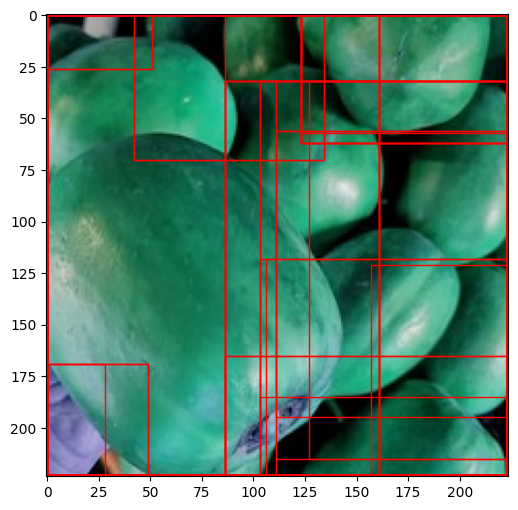

In [21]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from skimage.util import img_as_int

# Load the image
#image = cv2.imread('fridge_image.jpg')
image = cv2.imread('/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/test/Papaya/1225.jpg')

# Perform selective search to generate candidate regions
selective_search = selectivesearch.selective_search(image, scale=500, sigma=0.9, min_size=10)

# Set a threshold for the minimum bounding box size
min_box_size = 1000  # Adjust this value as needed
        
boxes = []     
for region in selective_search[1]:
    x, y, w, h = region['rect']
    if w * h >= min_box_size:
       boxes.append((x, y, x + w, y + h))  # Convert coordinates to integers
       
    

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(image)
for x, y, w, h in boxes:
    print(x, y, w, h)
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
        

In [22]:
image = cv2.imread('/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/test/Papaya/1225.jpg')
import os 
data_directory = '/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/train'

boxes = []     
for region in selective_search[1]:
    x, y, w, h = region['rect']
    if w * h >= min_box_size:
       boxes.append((x, y, x + w, y + h))  # Convert coordinates to integers
       
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

  

# Get the list of subdirectories (labels)
labels = sorted(os.listdir(data_directory))


show = box_label(image, boxes, labels)
#cv2.imshow(image) #if used in Python

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

In [27]:
image = cv2.imread('/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/test/Papaya/1225.jpg')
import os 
data_directory = '/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/train'

boxes = []     
for region in selective_search[1]:
    x, y, w, h = region['rect']
    if w * h >= min_box_size:
       boxes.append((x, y, x + w, y + h))  # Convert coordinates to integers
       
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (box[0], box[1]), (box[2], box[3])
  cv2.rectangle(image, p1, p2, color, thickness=int(lw), lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

  

# Get the list of subdirectories (labels)
labels = sorted(os.listdir(data_directory))


show = box_label(image, boxes, labels[0])
#cv2.imshow(image) #if used in Python

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - argument for rectangle() given by name ('thickness') and position (4)
>  - argument for rectangle() given by name ('thickness') and position (4)


In [14]:
import cv2
import os
import selectivesearch
image = cv2.imread('/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/test/Papaya/1225.jpg')
data_directory = '/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/train'


# Perform selective search to generate candidate regions
selective_search = selectivesearch.selective_search(image, scale=500, sigma=0.9, min_size=10)

# Set a threshold for the minimum bounding box size
#min_box_size = 1000  # Adjust this value as needed
boxes = []
for region in selective_search[1]:
    x, y, w, h = region['rect']
    #if w[0] * h[0] >= min_box_size:
    boxes.append((int(x[0]), int(y[0]), int(x[0] + w[0]), int(y[0] + h[0])))  # Convert coordinates to integers

def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)  # font thickness
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)

# Get the list of subdirectories (labels)
labels = sorted(os.listdir(data_directory))
 

for box in boxes:
    box_label(image, box, labels[0])  # Pass the desired label as the third argument (labels[0] in this example)

cv2.imshow('Object Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


/Users/lieselvranckx/.pyenv/versions/3.10.6/envs/veggideas/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


TypeError: 'int' object is not subscriptable

In [10]:
# Load the image
#image = cv2.imread('fridge_image.jpg')
image = cv2.imread('/Users/lieselvranckx/code/ArthurDercq/veggideas/raw_data/test/Papaya/1199.jpg')

# Perform selective search to generate candidate regions
selective_search = selectivesearch.selective_search(image, scale=500, sigma=0.9, min_size=10)

In [18]:
selective_search[1][4]['rect']

(35, 0, 12, 9)